In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet152


In [2]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\CARLOS CORDERO\Desktop\ToG_pretrain


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


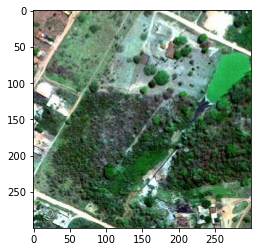

In [4]:
trainDB = currentPath + os.sep + "dataset" + os.sep + "train20"
valDB = currentPath + os.sep + "dataset"+ os.sep +"val20"
Resnet152WeightsPretrained = currentPath + os.sep + "resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_name = "Resnet152"
classList = os.listdir(trainDB)
classList.sort()

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00005
batch_size = 10
num_epochs = 200
num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

In [6]:
# First LR range analysis
# tensorboardLogsPath = "logs/lrfirtsstep/" + model_name
# LR fine tunning analysis
# tensorboardLogsPath = "logs/lrfine/" + model_name + "/lr-" + str(lr)
# model graph 
tensorboardLogsPath = "logs/modelgraph/" + model_name
tensorboardCallback = tensorflow.keras.callbacks.TensorBoard(tensorboardLogsPath)

In [7]:
# First LR range analysis
#def scheduler(epoch):
#    return (0.5 * (10**(-1*(epoch//20))))
#lrSchcallback = tensorflow.keras.callbacks.LearningRateScheduler(scheduler)

In [8]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 105 images belonging to 7 classes.
Found 34 images belonging to 7 classes.


In [9]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6}


In [10]:
input = Input(shape=(img_rows, img_cols, img_channel))

In [11]:
def ResnetCustom(shape,pretrainedweights, input_tensor, classes):
    RN152NoTop = ResNet152(
        include_top=False, weights=pretrainedweights, input_tensor=input_tensor, input_shape=shape)
    
    RN152Out = RN152NoTop.layers[-1].output
    x = GlobalAvgPool2D()(RN152Out)
    output = Dense(classes, activation="softmax")(x)
    model = Model(input_tensor, output)
        
    return model

In [12]:
model = ResnetCustom((img_rows, img_cols, img_channel),Resnet152WeightsPretrained, input, num_categories)

model.summary()
#plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Total params: 58,385,287
Trainable params: 58,233,863
Non-trainable params: 151,424
__________________________________________________________________________________________________


In [13]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
# First LR range
# optimizeFunc = Adam()
optimizeFunc = Adam(learning_rate=lr)
model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])

In [14]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[tensorboardCallback],
    # First LR range analysis
    #callbacks=[lrSchcallback, tensorboardCallback],
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
4/4 [==============================] - 5s 1s/step - loss: 2.3588 - categorical_accuracy: 0.1250 - val_loss: 2.3271 - val_categorical_accuracy: 0.1176
Epoch 2/200
4/4 [==============================] - 2s 591ms/step - loss: 1.8475 - categorical_accuracy: 0.3000 - val_loss: 2.4112 - val_categorical_accuracy: 0.1471
Epoch 3/200
4/4 [==============================] - 4s 983ms/step - loss: 1.6336 - categorical_accuracy: 0.3714 - val_loss: 2.5682 - val_categorical_accuracy: 0.1471
Epoch 4/200
4/4 [==============================] - 2s 590ms/step - loss: 1.2883 - categorical_accuracy: 0.6250 - val_loss: 2.6009 - val_categorical_accuracy: 0.0882
Epoch 5/200
4/4 [==============================] - 2s 594ms/step - loss: 1.3585 - categorical_accuracy: 0.5750 - val_loss: 2.6803 - val_categorical_accuracy: 0.1176
Epoch 6/200
4/4 [==============================] - 2s 593ms/step - loss: 1.1000 - categorical_accuracy

Epoch 49/200
4/4 [==============================] - 2s 600ms/step - loss: 0.1222 - categorical_accuracy: 0.9500 - val_loss: 5.6789 - val_categorical_accuracy: 0.1765
Epoch 50/200
4/4 [==============================] - 2s 600ms/step - loss: 0.1416 - categorical_accuracy: 0.9429 - val_loss: 5.1075 - val_categorical_accuracy: 0.1765
Epoch 51/200
4/4 [==============================] - 2s 600ms/step - loss: 0.0398 - categorical_accuracy: 1.0000 - val_loss: 6.2422 - val_categorical_accuracy: 0.1765
Epoch 52/200
4/4 [==============================] - 2s 538ms/step - loss: 0.0998 - categorical_accuracy: 0.9714 - val_loss: 5.5763 - val_categorical_accuracy: 0.1765
Epoch 53/200
4/4 [==============================] - 2s 601ms/step - loss: 0.0204 - categorical_accuracy: 1.0000 - val_loss: 6.4348 - val_categorical_accuracy: 0.1765
Epoch 54/200
4/4 [==============================] - 2s 602ms/step - loss: 0.0174 - categorical_accuracy: 1.0000 - val_loss: 6.4876 - val_categorical_accuracy: 0.2059
Epoc

4/4 [==============================] - 2s 606ms/step - loss: 0.0162 - categorical_accuracy: 1.0000 - val_loss: 3.8828 - val_categorical_accuracy: 0.2353
Epoch 148/200
4/4 [==============================] - 2s 605ms/step - loss: 0.0705 - categorical_accuracy: 0.9500 - val_loss: 3.8435 - val_categorical_accuracy: 0.1765
Epoch 149/200
4/4 [==============================] - 2s 605ms/step - loss: 0.0249 - categorical_accuracy: 1.0000 - val_loss: 4.0360 - val_categorical_accuracy: 0.1765
Epoch 150/200
4/4 [==============================] - 2s 605ms/step - loss: 0.0099 - categorical_accuracy: 1.0000 - val_loss: 3.9186 - val_categorical_accuracy: 0.1765
Epoch 151/200
4/4 [==============================] - 2s 545ms/step - loss: 0.0398 - categorical_accuracy: 1.0000 - val_loss: 3.8732 - val_categorical_accuracy: 0.1176
Epoch 152/200
4/4 [==============================] - 2s 603ms/step - loss: 0.0621 - categorical_accuracy: 0.9750 - val_loss: 3.7062 - val_categorical_accuracy: 0.2059
Epoch 153/20

In [15]:
model.save(currentPath + os.sep + "Resnet152Model.h5")
model.save_weights(currentPath + os.sep + "Resnet152Weights.h5")

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


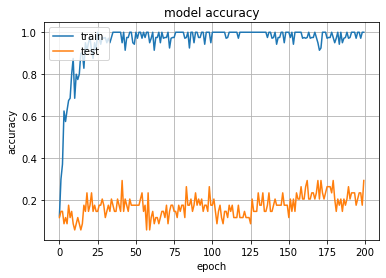

In [17]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

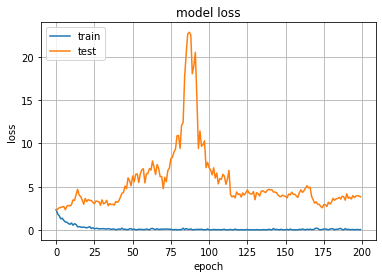

In [18]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [19]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( img_rows, img_cols))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_45_3_msrgb.jpg is: airport
file airport_55_0_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: airport


In [20]:
loadedModel = load_model("Resnet152Model.h5")

path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( img_rows, img_cols))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_45_3_msrgb.jpg is: airport
file airport_55_0_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: airport
